### Notebook 1 - Data preparation (Declining translation-rate model)

File to prepare mRNA and protein mean values per zone as well as SEMs for proteins for reimport in actual fit scripts. Protein profiles and SEMs are taken from spatial sorting results; mRNA profiles are derived scRNAseq data (see Methods). Also prepares linear interpolation functions for all mRNA curves and pickles a dictionary of them. In this model version, a function describing the global decline in translation rate is derived from translation efficiency data.

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import spearmanr
import dill as pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#### A) Raw data import, single cell data processing, filtering

In [2]:
# identify location of input data and output folders here
sc_counts_path = "input_data/table_B_scRNAseq_UMI_counts.tsv"
sc_meta_path = "input_data/table_C_scRNAseq_tsne_coordinates_zones.tsv"
protein_path = "input_data/protein_mRNA_data.xlsx"
output_folder = "processed_data"

In [3]:
# single cell data, import and processing into profiles
sc_counts_df = pd.read_csv(sc_counts_path, sep='\t', index_col=0).T
sc_meta_df = pd.read_csv(sc_meta_path, sep='\t', index_col=0)

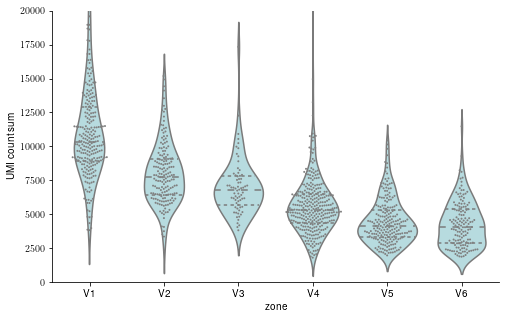

In [4]:
# get a rowsum and inspect plot
sc_counts_sum = sc_counts_df.sum(axis=1)
sc_counts_sum_df = pd.DataFrame.from_dict({'UMI count sum': sc_counts_sum.values, 'zone': sc_meta_df['zone']})

# remove crypt
sc_counts_sum_df  = sc_counts_sum_df[sc_counts_sum_df['zone'].isin(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'])]

# plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=sc_counts_sum_df, x='zone', y='UMI count sum', order=['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], color='powderblue', inner='quartile')
sns.swarmplot(data=sc_counts_sum_df, x='zone', y='UMI count sum', order=['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], color='grey', size=2)
plt.ylim((0, 20000))
sns.despine()
plt.savefig('figures/UMI_decline.pdf', bbox_inches='tight')

In [5]:
# merge zone ID to count df to group on
sc_counts_df['zone'] = sc_meta_df['zone']
M_data = sc_counts_df.groupby(['zone']).mean().T
# drop crypt
M_data = M_data.drop(['Crypt'], axis=1)

In [6]:
# read spatial sorting data from combined file
combined_data = pd.read_excel(protein_path, index_col=0, header=0)
# fix excel strings
combined_data.index = [x[1:-1] for x in combined_data.index]

In [7]:
# split into protein and protein errors
P_data = combined_data[[x for x in combined_data.columns if
                        x.startswith('protein')]]
Psem_data = combined_data[[x for x in combined_data.columns if
                           x.startswith('SEM')]]

In [8]:
# keep only values where sum of protein entries is larger than 0 AND
# the same is true for mRNA AND for SEMS
M_data_0 = M_data.loc[(P_data.sum(axis=1) > 0) &
                      (M_data.sum(axis=1) > 0) &
                      (Psem_data.sum(axis=1) > 0)].copy()
P_data_0 = P_data.loc[(P_data.sum(axis=1) > 0) &
                      (M_data.sum(axis=1) > 0) &
                      (Psem_data.sum(axis=1) > 0)].copy()
Psem_data_0 = Psem_data.loc[(P_data.sum(axis=1) > 0) &
                            (M_data.sum(axis=1) > 0) &
                            (Psem_data.sum(axis=1) > 0)].copy()

In [9]:
# we cannot accept 0 errors for philosophical and computational reasons,
# thus we require that every error that is 0 be set to 1/2 the mean error
# of that gene first calculate the mean error
SEM_mean_ser = Psem_data_0.mean(axis=1)
# next, find fields that have0 error and
# replace their error by 1/2 of the mean
for zone in Psem_data.columns:
    Psem_data_0.loc[Psem_data_0[zone] == 0, zone] = \
        1/2*SEM_mean_ser.loc[Psem_data_0[zone] == 0]

In [10]:
# sort all data alphabetically
M_data_0.sort_index(inplace=True)
P_data_0.sort_index(inplace=True)
Psem_data_0.sort_index(inplace=True)

#### B) Protein data - normalisation using cell volume estimates 

In [11]:
cell_size_path = "input_data/cell_size_estimation.csv"

In [12]:
# import cell size data and add volume column based on
# cylindrical model
size_df = pd.read_csv(cell_size_path)
size_df['Radius'] = 0.5*size_df['Area']/size_df['Length']
size_df['Volume'] = np.pi * size_df['Radius']**2 * size_df['Length']

In [13]:
time_vec3 = np.array([0, 48, 96])
vol_medians = size_df.groupby(['position']).median()['Volume'].values
size_df.groupby(['position']).median()

,Area,Length,ID,Radius,Volume
position,,,,,
bottom,17879.5,286.1425,6.5,30.495128,8.655730e+05
middle,21831.0,263.5220,6.5,41.925331,1.381002e+06
tip,22492.0,299.0115,6.5,39.180130,1.397836e+06


In [14]:
# as a function to interpolate this saturation, use 1- decaying exponential
def sat_fun(vals, lam=1, V_max=vol_medians[2], V_min=vol_medians[0]):
    return (V_max-V_min)*(1 - np.exp(-vals*lam)) + V_min

In [15]:
# define residual function for use in scipy minimize
def residuals(lam):
    # return sum of squared residuals
    ssr = np.sum((vol_medians - sat_fun(time_vec3, lam))**2)
    return ssr

In [16]:
minres = minimize(residuals, 0.1, method='nelder-mead')

In [17]:
minres.x

array([0.07199465])

(0.0, 1424448.9483939188)

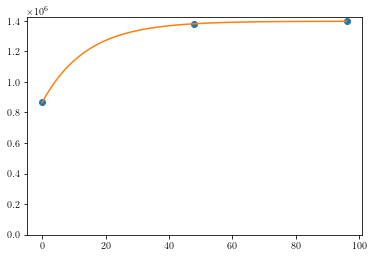

In [18]:
plt.plot(time_vec3, vol_medians, 'o')
plt.plot(np.linspace(0, 96, 100), sat_fun(np.linspace(0,96,100), minres.x))
plt.ylim(bottom=0)

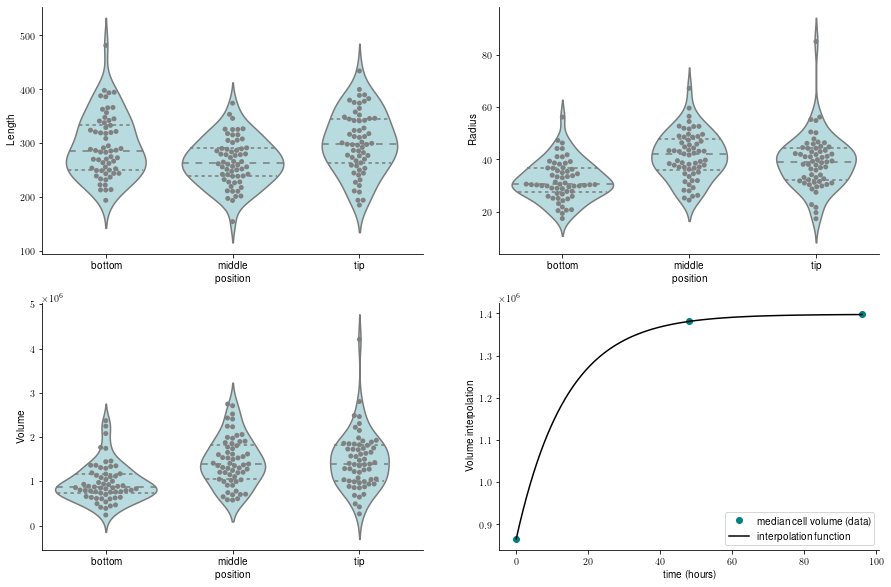

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.violinplot(data=size_df, x='position', y='Length', ax=axes[0,0], color='powderblue', inner='quartile')
sns.swarmplot(data=size_df, x='position', y='Length', ax=axes[0,0], color='grey')

sns.violinplot(data=size_df, x='position', y='Radius', ax=axes[0,1], color='powderblue', inner='quartile')
sns.swarmplot(data=size_df, x='position', y='Radius', ax=axes[0,1], color='grey')

sns.violinplot(data=size_df, x='position', y='Volume', ax=axes[1,0], color='powderblue', inner='quartile')
sns.swarmplot(data=size_df, x='position', y='Volume', ax=axes[1,0], color='grey')

plt.plot(time_vec3, vol_medians, 'o', color='teal', label='median cell volume (data)')
axes[1,1].plot(np.linspace(0, 96, 100), sat_fun(np.linspace(0,96,100), minres.x), color='black', label='interpolation function')
axes[1,1].set_xlabel('time (hours)')
axes[1,1].set_ylabel('Volume interpolation')
axes[1,1].legend(loc=0)

sns.despine()
plt.savefig('figures/cell_size_increase.pdf', bbox_inches='tight')

In [20]:
# time vector for zone correction
time_vec6 = np.linspace(0, 96, 6)

In [21]:
# get value of the saturating function at the 6 times
# in this time vector and mean-normalize before application
# to the data
corr_vals = sat_fun(time_vec6, lam=minres.x)
corr_vals = corr_vals/np.mean(corr_vals)

In [22]:
# each protein value and its associated error need to be multiplied
# by the zone-specific correction factor
for i, zone in enumerate(P_data_0.columns):
    P_data_0[zone] = P_data_0[zone]*corr_vals[i]
    Psem_data_0[Psem_data_0.columns[i]] = Psem_data_0[Psem_data_0.columns[i]]*corr_vals[i]

In [23]:
# sort the indices alphabetically
M_data_0 = M_data_0.sort_index()
P_data_0 = P_data_0.sort_index()
Psem_data_0 = Psem_data_0.sort_index()

In [24]:
# get mean-normalized versions of both data sets for better interpretability
# at the gene level
M_data_meannorm = M_data_0.div(M_data_0.mean(axis=1), axis=0)
P_data_meannorm = P_data_0.div(P_data_0.mean(axis=1), axis=0)
Psem_data_meannorm = Psem_data_0.div(P_data_0.mean(axis=1), axis=0)

#### C) Scale our protein and mRNA values, which currently come as arbitrary units, to realistic units with the help of Schwanhäusser orders of magnitude

In [25]:
# import Schwanhäusser data
schwan_df = pd.read_excel('external_data/Schwanhaeusser_simple.xlsx', index_col=0, header=0)

In [26]:
# the index of the schwanhäusser data needs to be cleaned up first
# for each gene in results_df, find the partnering schwanhäusser name
# and write it to dict as schwan: our name
schwan_dict = {}
for gene in M_data_meannorm.index:
    for schwan in schwan_df.index:
        write=False
        try:
            if gene in schwan.split(';'):
                write=True
                break
        except AttributeError: # for skipping schwanhäusser empty lines
            pass
    if write:
        schwan_dict[schwan] = gene

In [27]:
# use the dict to rename the Schwanhäusser data
new_index = [schwan_dict[x] if x in schwan_dict.keys() else x for x in schwan_df.index]

In [28]:
schwan_df.index = new_index

In [29]:
# remove duplicates from schwan index
schwan_df = schwan_df.groupby(schwan_df.index).mean()

In [30]:
# extract genes which appear in both dfs
schwan_double_genes = [x for x in M_data_meannorm.index if x in schwan_df.index]

In [31]:
# collect means of mRNA and protein in a separate df
M_means = M_data_0.mean(axis=1).values
P_means = P_data_0.mean(axis=1).values
mean_df = pd.DataFrame(data=np.vstack((M_means, P_means)).T, index=M_data_0.index, columns=['M_mean', 'P_mean'])

In [32]:
schwan_combi = pd.concat([mean_df.loc[schwan_double_genes],
                          schwan_df.loc[schwan_double_genes]], axis=1)

In [33]:
schwan_combi.columns

Index(['M_mean', 'P_mean', 'S Protein copy [molecules/cell]',
       'S mRNA copy number [molecules/cell]', 'S Protein half-life [h]',
       'S mRNA half-life [h]', 'S transcription rate [molecules/(cell*h)]',
       'S translation rate constant [molecules/(mRNA*h)]'],
      dtype='object')

In [34]:
# add log column for M and P values
for col in ['M_mean', 'P_mean', 'S Protein copy [molecules/cell]', 'S mRNA copy number [molecules/cell]']:
    schwan_combi['log '+ col] = np.log(schwan_combi[col]) 

In [35]:
# drop nan rows for this analysis
schwan_combi.dropna(inplace=True)

#### First for protein, inspect histogrammes and correct our data using median

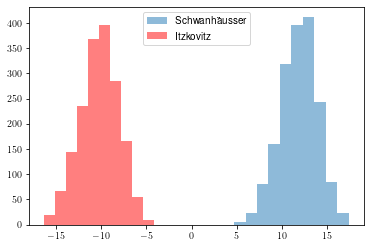

In [36]:
plt.hist(schwan_combi['log S Protein copy [molecules/cell]'], label='Schwanhäusser', alpha=0.5)
plt.hist(schwan_combi['log P_mean'], color='red', label='Itzkovitz', alpha=0.5)
plt.legend()

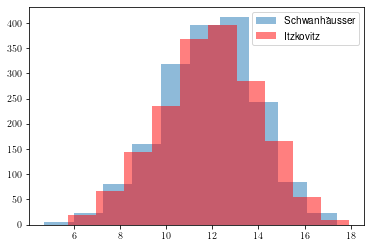

In [37]:
# shift our logged data accordingly
med_dist_P = schwan_combi['log S Protein copy [molecules/cell]'].median() - schwan_combi['log P_mean'].median()
plt.hist(schwan_combi['log S Protein copy [molecules/cell]'], label='Schwanhäusser', alpha=0.5)
plt.hist(schwan_combi['log P_mean'] + med_dist_P, color='red', label='Itzkovitz', alpha=0.5)
plt.legend()

In [38]:
# actual transformation must be applied to the whole dataframe
P_data_0_scaled = P_data_0 * schwan_combi['S Protein copy [molecules/cell]'].median() / schwan_combi['P_mean'].median()
Psem_data_0_scaled = Psem_data_0 * schwan_combi['S Protein copy [molecules/cell]'].median() / schwan_combi['P_mean'].median()

#### Similarly for mRNA

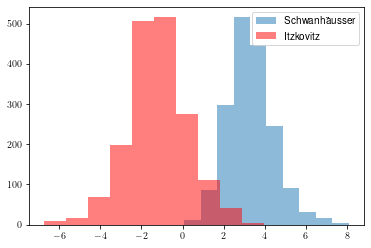

In [39]:
plt.hist(schwan_combi['log S mRNA copy number [molecules/cell]'], label='Schwanhäusser', alpha=0.5)
plt.hist(schwan_combi['log M_mean'], color='red', label='Itzkovitz', alpha=0.5)
plt.legend()

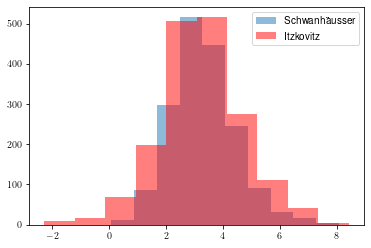

In [40]:
med_dist_M = schwan_combi['log S mRNA copy number [molecules/cell]'].median() - schwan_combi['log M_mean'].median()
plt.hist(schwan_combi['log S mRNA copy number [molecules/cell]'], label='Schwanhäusser', alpha=0.5)
plt.hist(schwan_combi['log M_mean'] + med_dist_M, color='red', label='Itzkovitz', alpha=0.5)
plt.legend()

In [41]:
# actual transformation must be applied to the whole dataframe
M_data_0_scaled =  M_data_0 * schwan_combi['S mRNA copy number [molecules/cell]'].median() / schwan_combi['M_mean'].median()

In [42]:
# build mean dataframe again from the new scaled profiles
# collect means of mRNA and protein in a separate df
M_means_scaled = M_data_0_scaled.mean(axis=1).values
P_means_scaled = P_data_0_scaled.mean(axis=1).values
mean_df_scaled = pd.DataFrame(data=np.vstack((M_means_scaled, P_means_scaled)).T, index=M_data_0_scaled.index, columns=['M_mean_scaled', 'P_mean_scaled'])

In [43]:
# as double check, also build combined df again
schwan_combi = pd.concat([mean_df_scaled.loc[schwan_double_genes],
                          schwan_df.loc[schwan_double_genes]], axis=1)
# add log column for M and P values
for col in ['M_mean_scaled', 'P_mean_scaled', 'S Protein copy [molecules/cell]', 'S mRNA copy number [molecules/cell]']:
    schwan_combi['log '+ col] = np.log(schwan_combi[col]) 
schwan_combi.dropna(inplace=True)

In [44]:
# add P over M columns
schwan_combi['S P_over_M'] = schwan_combi['S Protein copy [molecules/cell]']/schwan_combi['S mRNA copy number [molecules/cell]']
schwan_combi['P_over_M'] = schwan_combi['P_mean_scaled']/schwan_combi['M_mean_scaled']

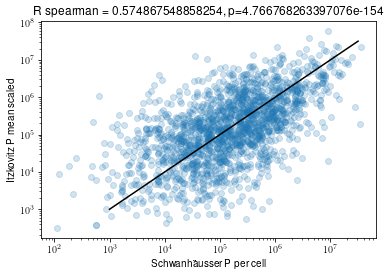

In [45]:
plt.scatter(schwan_combi['S Protein copy [molecules/cell]'], schwan_combi['P_mean_scaled'], alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Itzkovitz P mean scaled')
plt.xlabel('Schwanhäusser P per cell')
Rspear = spearmanr(schwan_combi['S Protein copy [molecules/cell]'], schwan_combi['P_mean_scaled'])
plt.title(r'R spearman = {}, p={}'.format(Rspear[0], Rspear[1]))
plt.plot(np.logspace(3, 7.5, 100), np.logspace(3, 7.5, 100), 'k')

In [46]:
schwan_combi.median(axis=0)

M_mean_scaled                                           24.890000
P_mean_scaled                                       151581.100000
S Protein copy [molecules/cell]                     151581.100000
S mRNA copy number [molecules/cell]                     24.890000
S Protein half-life [h]                                 61.840000
S mRNA half-life [h]                                    11.380000
S transcription rate [molecules/(cell*h)]                2.270000
S translation rate constant [molecules/(mRNA*h)]       228.880000
log M_mean_scaled                                        3.214466
log P_mean_scaled                                       11.928876
log S Protein copy [molecules/cell]                     11.928876
log S mRNA copy number [molecules/cell]                  3.214466
S P_over_M                                            6102.415959
P_over_M                                              6357.633690
dtype: float64

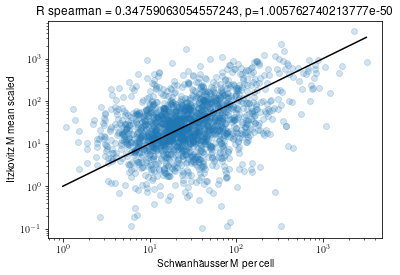

In [47]:
plt.scatter(schwan_combi['S mRNA copy number [molecules/cell]'], schwan_combi['M_mean_scaled'], alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Itzkovitz M mean scaled')
plt.xlabel('Schwanhäusser M per cell')
Rspear = spearmanr(schwan_combi['S mRNA copy number [molecules/cell]'], schwan_combi['M_mean_scaled'])
plt.title('R spearman = {}, p={}'.format(Rspear[0], Rspear[1]))
plt.plot(np.logspace(0, 3.5, 100), np.logspace(0, 3.5, 100), 'k')

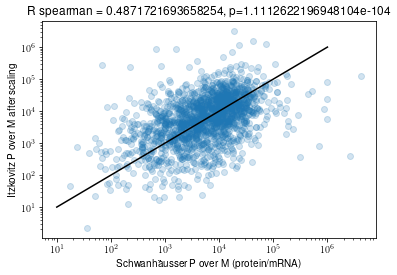

In [48]:
plt.scatter(schwan_combi['S P_over_M'], schwan_combi['P_over_M'], alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Itzkovitz P over M after scaling')
plt.xlabel('Schwanhäusser P over M (protein/mRNA)')
Rspear = spearmanr(schwan_combi['S P_over_M'], schwan_combi['P_over_M'])
plt.title('R spearman = {}, p={}'.format(Rspear[0], Rspear[1]))
plt.plot(np.logspace(1, 6, 100), np.logspace(1, 6, 100), 'k')

#### D) Export of scaled and volume-transformed protein and mRNA data

In [49]:
# export these dataframes to the processed data folder
M_data_0_scaled.to_csv(output_folder+"/M_data_sc_based_scaled.csv",
                       index=True, header=True)
P_data_0_scaled.to_csv(output_folder+"/P_data_vol_corrected_scaled.csv",
                       index=True, header=True)
Psem_data_0_scaled.to_csv(output_folder+"/Psem_data_vol_corrected_scaled.csv",
                          index=True, header=True)

In [50]:
mean_df_scaled.to_csv(output_folder+"/P_and_M_means.csv")

#### E) Linear interpolation of mRNA profiles

In [51]:
# next, get linear interpolation of the mRNA profiles
# define time values in hours
time_vec = np.linspace(0, 96, 6)
# let's store the interpolation functions in a dict
M_interp_dict = {}

In [52]:
# go through all genes, get the interp function, write it to dict
for gene in M_data_0_scaled.index.tolist():
    # interpolate
    M_this_fun = interp1d(time_vec, M_data_0_scaled.loc[gene].tolist(),
                          kind='slinear', fill_value='extrapolate')
    # store
    M_interp_dict[gene] = M_this_fun

In [53]:
# pickle the dict to file
with open(output_folder+"/M_interp_dict", 'wb') as file:
    pickle.dump(M_interp_dict, file)

In [54]:
# finally, also pickle to file a list of all gene names to facilitate
# cluster job distribution
gene_names = M_data_0_scaled.index.tolist()
with open("processed_data/gene_names", 'wb') as file:
    pickle.dump(gene_names, file)
# in order to automatically write cluster jobs elsewhere, make csv of gene names as well
import csv
with open("processed_data/gene_names.csv", 'w') as file:
    for word in gene_names:
        file.write(word + ' ')

#### F) Interpolation of decline in translation efficiency 

In [55]:
# import stratified translation efficiency data
TE_strat_df = pd.read_csv('external_data/TE_zone_stratified_median_values.txt', sep='\s+')
TE_strat_vec = np.array(TE_strat_df['TE'].to_list())

In [56]:
TE_strat_vec

array([0.9231, 0.6585, 0.643 ])

In [57]:
time_strat_vec=np.array([0,48,96])

In [58]:
# as a function to interpolate this decline, use decaying exponential
# with min and max values defined by the data, decay rate to be fitted
def sat_fun2(vals, lam=1, TE_max=np.max(TE_strat_vec), TE_min=np.min(TE_strat_vec)):
    return (TE_max-TE_min)* np.exp(-(vals-time_strat_vec[0])*lam) + TE_min

In [59]:
sat_fun2(time_strat_vec, lam=1.011)

array([0.9231, 0.643 , 0.643 ])

In [60]:
# define residual function for use in scipy minimize
def residuals2(lam):
    # return sum of squared residuals
    ssr = np.sum((TE_strat_vec - sat_fun2(time_strat_vec, lam))**2)
    return ssr
# run minimization
minres = minimize(residuals2, 0.07)

In [61]:
minres.x

array([0.06042736])

(0.0, 0.9371050000000001)

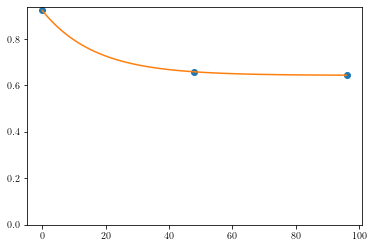

In [62]:
plt.plot(time_strat_vec, TE_strat_vec, 'o')
plt.plot(np.linspace(0, 96, 100), sat_fun2(np.linspace(0,96,100), minres.x))
plt.ylim(bottom=0)

In [63]:
# redefine the TE decay function with fixed values for integration and normalisation
def TE_fun(vals, lam=minres.x, TE_max=np.max(TE_strat_vec), TE_min=np.min(TE_strat_vec)):
    return (TE_max-TE_min)* np.exp(-(vals-time_strat_vec[0])*lam) + TE_min

In [64]:
# integrate this function, in order to maintain maximum comparability
# with stable TE model, normalise to the integral under a constant (1)
# from 0 to 96 hours
from scipy import integrate
TE_int, _ = integrate.quad(TE_fun, 0, 96)

TE_int

66.3492985049082

In [65]:
# for dill-pickled export, all values need to be given explicitly
def TE_fun_norm(vals, lam=0.06042736, TE_max=0.9231, TE_min=0.643):
    TE_fun_val = (TE_max-TE_min)* np.exp(-(vals)*lam) + TE_min
    TE_fun_val_norm = TE_fun_val/66.0589*96
    return TE_fun_val_norm

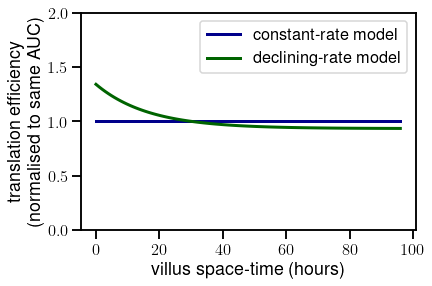

In [66]:
sns.set_context('talk')
plt.plot(np.linspace(0, 96, 100), [1 for i in range(100)], label='constant-rate model', linewidth=3, linestyle='-', color='darkblue')
plt.plot(np.linspace(0, 96, 100), TE_fun_norm(np.linspace(0,96,100), minres.x), label='declining-rate model', linewidth=3, linestyle='-', color='darkgreen')
plt.ylim([0, 2])
plt.legend(loc=0)
plt.xlabel('villus space-time (hours)')
plt.ylabel('translation efficiency\n(normalised to same AUC)')
plt.savefig('figures/TE_comparison.pdf', bbox_inches='tight')

In [67]:
TE_fun_norm(np.linspace(0,96,10), minres.x)

array([1.34149373, 1.1480996 , 1.04658813, 0.99330534, 0.96533752,
       0.95065736, 0.94295184, 0.93890725, 0.93678427, 0.93566993])

In [68]:
# pickle the function for use in parameter estimation procedure
with open(output_folder+"/TE_decay_function", 'wb') as file:
    pickle.dump(TE_fun_norm, file)